#### 1. Data import and device

In [1]:
from IPython.display import display
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from pathlib import Path
from collections import Counter
import pandas as pd
import plotly.express as px

In [2]:
# --- config ---
ROOT = Path().resolve()
DATA_DIR = os.path.join(ROOT, "data", "archive", "Dataset")
IMG_SIZE = 224
BATCH_SIZE = 64
VAL_SPLIT = 0.2
SEED = 42
NUM_WORKERS = 2
PIN = torch.cuda.is_available()

# --- transforms ---
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(0.1, 0.1, 0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


def get_loaders(
        data_dir: str = DATA_DIR,
        batch_size: int = BATCH_SIZE,
        val_split: float = VAL_SPLIT,
        seed: int = SEED,
        num_workers: int = NUM_WORKERS,
        pin_memory: bool = PIN,
):
    full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_tf)
    n = len(full)
    n_val = int(n * val_split)
    n_train = n - n_val

    g = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(full, [n_train, n_val], generator=g)

    # clean tf for val
    val_set.dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_tf)

    class_to_idx = full.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size * 2, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    return train_loader, val_loader, idx_to_class


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, idx_to_class = get_loaders()

xb, yb = next(iter(train_loader))


#### 2.Data visualization

show image amount, show class amount,and batch size

In [3]:
print("Using device:", device)
print(f"Total images: {len(train_loader.dataset) + len(val_loader.dataset)}  |  "
      f"Train: {len(train_loader.dataset)}  Val: {len(val_loader.dataset)}")
print("Num classes:", len(idx_to_class))
print("Classes:", list(idx_to_class.values()))
print("Batch:", xb.shape, yb.shape)


Using device: cpu
Total images: 35725  |  Train: 28580  Val: 7145
Num classes: 23
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


Display the first 10 images from the dataset.
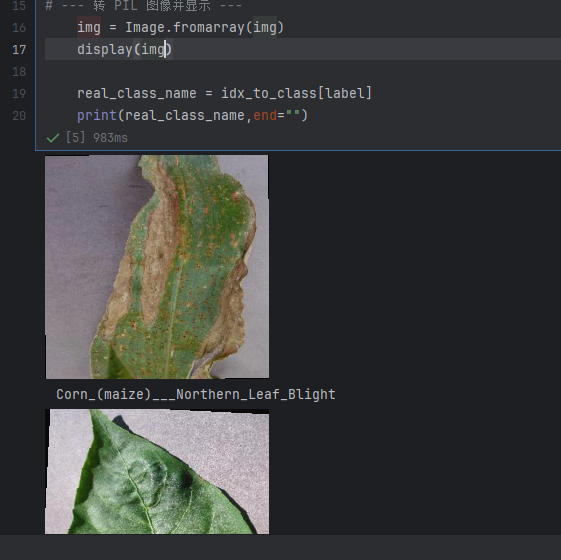

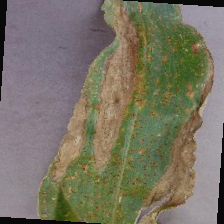

Corn_(maize)___Northern_Leaf_Blight

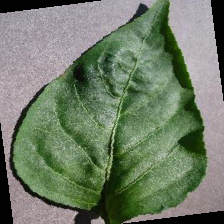

Pepper__bell___healthy

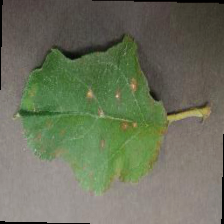

Apple___Cedar_apple_rust

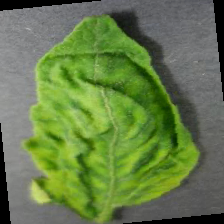

Tomato__Tomato_YellowLeaf__Curl_Virus

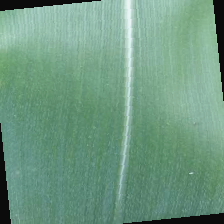

Corn_(maize)___healthy

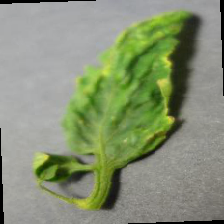

Tomato__Tomato_YellowLeaf__Curl_Virus

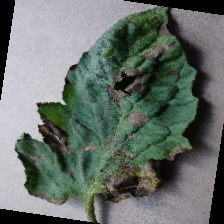

Tomato_Early_blight

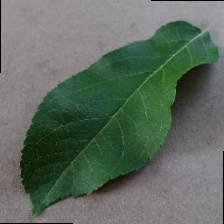

Apple___healthy

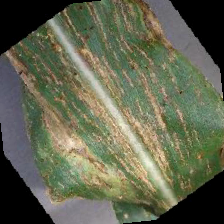

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

In [4]:
dataset = train_loader.dataset
for i in range(9):
    img, label = dataset[i]
    # --- 反归一化 ---
    img = img.detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if img.shape[0] == 3:
        img = img * std + mean

    # --- CHW -> HWC + 转成 0~255 uint8 ---
    img = img.permute(1, 2, 0).clamp(0, 1)  # HWC, [0,1]
    img = (img * 255).byte().numpy()  # uint8 array

    # --- 转 PIL 图像并显示 ---
    img = Image.fromarray(img)
    display(img)

    real_class_name = idx_to_class[label]
    print(real_class_name, end="")

Count images per class to check class balance.

In [5]:
labels = []
for img, label in dataset:
    labels.append(idx_to_class[label])

print(Counter(labels))

Counter({'Tomato__Tomato_YellowLeaf__Curl_Virus': 2555, 'Tomato_Bacterial_spot': 1738, 'Apple___healthy': 1630, 'Apple___Apple_scab': 1627, 'Apple___Black_rot': 1584, 'Tomato_Late_blight': 1535, 'Corn_(maize)___Northern_Leaf_Blight': 1519, 'Corn_(maize)___Common_rust_': 1518, 'Corn_(maize)___healthy': 1500, 'Tomato_Septoria_leaf_spot': 1419, 'Apple___Cedar_apple_rust': 1408, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1321, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1305, 'Tomato_healthy': 1254, 'Pepper__bell___healthy': 1188, 'Tomato__Target_Spot': 1138, 'Potato___Late_blight': 809, 'Potato___Early_blight': 805, 'Tomato_Early_blight': 793, 'Pepper__bell___Bacterial_spot': 783, 'Tomato_Leaf_Mold': 750, 'Tomato__Tomato_mosaic_virus': 279, 'Potato___healthy': 122})


In [10]:
count = Counter(labels)

# 构造 DataFrame（关键在这里）
df = pd.DataFrame(sorted(count.items(), key=lambda x: x[0]), columns=["class", "count"])

# 直接可视化（Jupyter里自动显示，不会卡）
fig = px.bar(df, x="class", y="count", title="Class Distribution", text="count")
fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=-45)

display(fig)

#### 3. Data cleaning

#### 4. Model and comparison model

#### 5. Model training

#### 6. Model performance comparison & CV